In [5]:
import os

def get_repo_dir():
    cwd = os.getcwd()
    splited = cwd.split('/')
    ind = splited.index('fsCounter')
    repo_dir = '/'
    for s in splited[1:ind + 1]:
        repo_dir = os.path.join(repo_dir, s)

    return repo_dir

In [23]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.linear_model import LinearRegression

sys.path.append(get_repo_dir())

from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *
from vision.tools.post_process_analysis import read_tracks_and_slices, get_block_count
from vision.visualization.draw_bb_from_csv import draw_tree_bb_from_tracks

In [7]:
harvest_size_and_weight_path = "/home/matans/Documents/fruitspec/sandbox/syngenta/harvest_size_and_weight_291123.csv"

In [8]:
harvest_df = pd.read_csv(harvest_size_and_weight_path)

<Axes: >

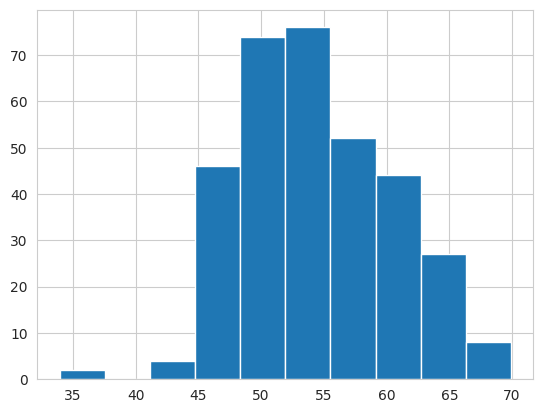

In [11]:
harvest_df['Height'].hist()

In [16]:
a = np.array(harvest_df['Height'] / 2)
b = np.array(harvest_df['Width'] / 2)
v = np.pi * 4 * (np.power((a * a),(1/3)) + 2 * np.power((a * b),(1/3))) / 3 

harvest_df['elipse'] = v
harvest_df['size'] = a * b

<Axes: >

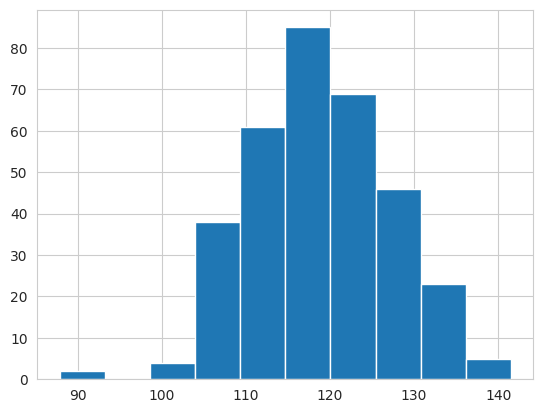

In [17]:
harvest_df['elipse'].hist()

<Axes: >

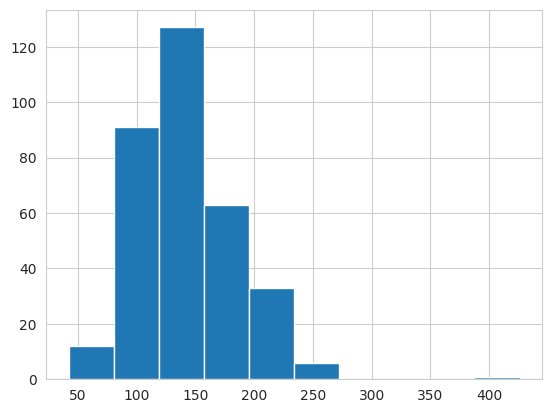

In [19]:
harvest_df['Weight'].hist()

<Axes: >

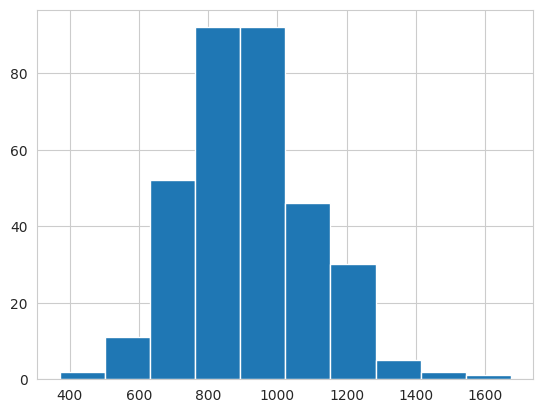

In [18]:
harvest_df['size'].hist()

<Axes: xlabel='elipse', ylabel='Weight'>

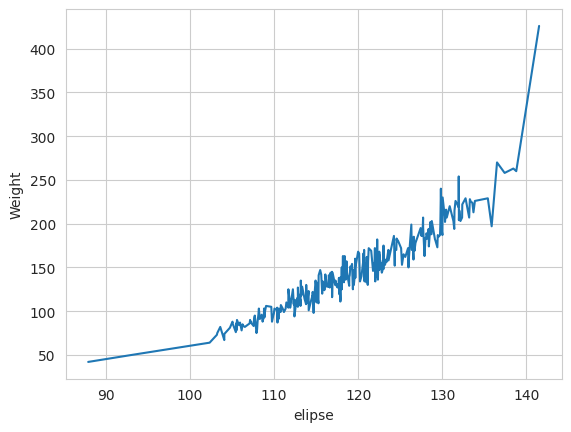

In [21]:
sns.lineplot(data=harvest_df,x='elipse', y='Weight')

<Axes: xlabel='size', ylabel='Weight'>

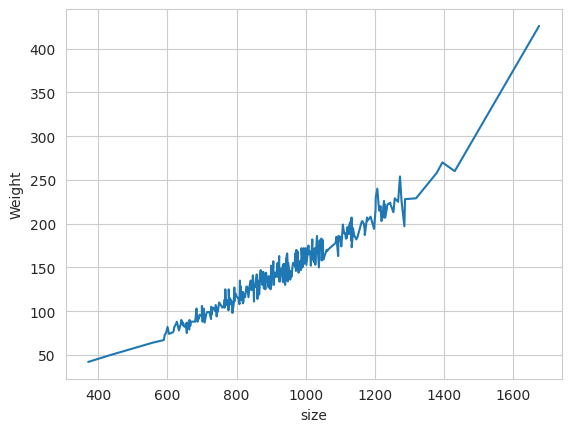

In [22]:
sns.lineplot(data=harvest_df,x='size', y='Weight')

In [ ]:
model = LinearRegression(fit_intercept=fit_intercept)
model.fit(